# Installations/Préparations

## install

In [1]:
!pip install importlib-metadata==4.13.0
#!pip install setuptools==65.5.0
#!pip install git+https://github.com/osigaud/bbrl_gym
!pip install git+https://github.com/osigaud/bbrl
!pip install omegaconf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/osigaud/bbrl to /tmp/pip-req-build-cv0e37ya
  Running command git clone --filter=blob:none --quiet https://github.com/osigaud/bbrl /tmp/pip-req-build-cv0e37ya
  Resolved https://github.com/osigaud/bbrl to commit cb2c22b82bfedfb04d8232ba432cdbd798fd797a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bbrl: filename=bbrl-0.1.10.dev4+gcb2c22b-py3-none-any.whl size=55867 sha256=c0775f14fd3eee3c06728490f0ad648f7c058b66954394258b03ccdf123b9528
  Stored in directory: /tmp/pip-ephem-wheel-cache-hpegbj48/wheels/81/c7/a1/1cd3a7fa9eb4ee4fb2361971e761bf4d773836b6c210fbcd85
Successfully built bbrl
Looking in indexes: https://pyp

## import

In [2]:
from bbrl.workspace import Workspace
from bbrl import get_class, get_arguments, instantiate_class

#import bbrl_gym
import gym

from bbrl.agents.agent import Agent
from bbrl.agents import Agents, TemporalAgent, PrintAgent
from bbrl.agents.gymb import NoAutoResetGymAgent

from bbrl.utils.replay_buffer import ReplayBuffer
from bbrl.utils.chrono import Chrono

from bbrl.visu.visu_policies import plot_policy
from bbrl.visu.visu_critics import plot_critic
from bbrl.visu.common import final_show

from omegaconf import OmegaConf
from omegaconf import DictConfig

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import numpy as np
import time
import matplotlib
import os
import functools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import copy

# Implémentations depuis bbrl_examples

In [3]:
class Logger:
    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, epoch):
        self.logger.add_scalar(log_string, loss.item(), epoch)

    # Log losses
    def log_losses(self, epoch, critic_loss, entropy_loss, actor_loss):
        self.add_log("critic_loss", critic_loss, epoch)
        self.add_log("entropy_loss", entropy_loss, epoch)
        self.add_log("actor_loss", actor_loss, epoch)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

def format_num(num, pos):
    # Pos is a required parameter, but it is not used
    magnitude = 0
    labels = ["", "K", "M", "G"]
    while abs(num) >= 1e3:
        magnitude += 1
        num /= 1e3

    return f"{num:.1f}{labels[magnitude]}"

class Plotter:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename

    def plot_reward(
        self,
        algo_name,
        env_name,
        mode="mean",
        prefix="",
        suffix=".pdf",
        save_fig=True,
        save_dir="./plots/",
    ):
        _, ax = plt.subplots(figsize=(9, 6))
        formatter = FuncFormatter(format_num)

        colors = ["#09b542", "#008fd5", "#fc4f30", "#e5ae38", "#e5ae38", "#810f7c"]
        color = colors[0]

        loader = RewardLoader(self.steps_filename, self.rewards_filename)
        steps, rewards = loader.load()
        print(steps, rewards)
        # steps, rewards = equalize_lengths(steps, rewards)

        if mode == "best":
            best = rewards.sum(axis=1).argmax()
            mean = rewards[best]
        elif mode == "max":
            mean = np.max(rewards, axis=0)
        else:
            std = rewards.std(axis=0)
            mean = rewards.mean(axis=0)
            ax.fill_between(steps, mean + std, mean - std, alpha=0.1, color=color)
        ax.plot(steps, mean, lw=2, label=f"{algo_name}", color=color)
        ax.xaxis.set_major_formatter(formatter)
        plt.legend()

        save_dir += f"{env_name}/"

        clean_env_name = env_name.split("-")[0]
        figure_name = f"{prefix}{clean_env_name.lower()}_{mode}"
        title = f"{clean_env_name} ({mode})"
        if suffix:
            figure_name += f"{suffix}"
        final_show(save_fig, True, save_dir, figure_name, "timesteps", "rewards", title)

    def plot_histograms(
        self,
        rewards,
        env_name,
        suffix="",
        save_dir="./plots/",
        plot=True,
        save_fig=True,
    ):
        plt.figure(figsize=(9, 6))

        colors = ["#09b542", "#008fd5", "#fc4f30", "#e5ae38", "#e5ae38", "#810f7c"]
        # colors = ["#fc4f30", "#008fd5", "#e5ae38"]

        n_bars = len(rewards)
        x = np.arange(len(list(rewards.values())[0]))
        width = 0.75 / n_bars

        for i, reward in enumerate(rewards.values()):
            plt.bar(x + width * i, np.sort(reward)[::-1], width=width, color=colors[i])

        plt.legend(labels=rewards.keys())
        plt.xticks([], [])

        save_dir += f"{env_name}/"

        clean_env_name = env_name.split("-")[0]
        title = clean_env_name
        figure_name = f"{clean_env_name.lower()}-histograms"

        if suffix:
            title += f" ({suffix})"
            figure_name += f"{suffix}"

        final_show(save_fig, plot, save_dir, figure_name, "", "rewards", title)

class RewardLogger:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename
        self.episode = 0
        self.all_rewards = []
        self.all_rewards.append([])
        self.all_steps = []

    def add(self, nb_steps, reward):
        if self.episode == 0:
            self.all_steps.append(nb_steps)
        self.all_rewards[self.episode].append(reward.item())

    def new_episode(self):
        self.episode += 1
        self.all_rewards.append([])

    def save(self):
        # print("reward loader save:", self.all_steps,  self.all_rewards)
        with open(self.steps_filename, "ab") as f:
            np.save(f, self.all_steps)
        with open(self.rewards_filename, "ab") as f:
            np.save(f, self.all_rewards)

class RewardLoader:
    def __init__(self, steps_filename, rewards_filename):
        self.steps_filename = steps_filename
        self.rewards_filename = rewards_filename

    def load(self):
        with open(self.steps_filename, "rb") as f:
            steps = np.load(f, allow_pickle=True)
        with open(self.rewards_filename, "rb") as f:
            rewards = np.load(f, allow_pickle=True)
        return steps, rewards

In [4]:
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

def build_alt_mlp(sizes, activation):
    layers = []
    for j in range(len(sizes) - 1):
        if j < len(sizes) - 2:
            layers += [nn.Linear(sizes[j], sizes[j + 1]), activation]
        else:
            layers += [nn.Linear(sizes[j], sizes[j + 1])]
    return nn.Sequential(*layers)


class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t, **kwargs):
        q_values = self.get(("q_values", t))
        nb_actions = q_values.size()[1]
        size = q_values.size()[0]
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]
        action = is_random * random_action + (1 - is_random) * max_action
        action = action.long()
        self.set(("action", t), action)

# Nouveaux Agents & Wrapper

In [5]:
class GoalRelabellingAgent(Agent):
    def __init__(self):
        super().__init__()

    def forward(self, t, batch_size=1, desired_goal=None, choice=False, **kwargs):
        if desired_goal != None:
            # modification du but désiré par le but atteind
            desired_goal = desired_goal.to(torch.float64)
            self.set(("env/desired_goal", t), desired_goal)

        if choice:
            # choix arbitraire d'un goal
            pos = np.random.uniform(-2.4, 2.4, batch_size)
            vel = np.random.uniform(-1, 1, batch_size)
            angle = np.random.uniform(-.2095, .2095, batch_size)
            angle_vel = np.random.uniform(-1, 1, batch_size)

            # choix d'une distance acceptable
            epsilon_goal = torch.Tensor([0.5, 0.9, 0.05, 0.9])
            epsilon_goal = torch.tile(epsilon_goal, (batch_size, 1))

            # set du paramètre goal de l'environnement
            goal = np.stack((pos, vel, angle, angle_vel), axis=1)
            t_goal = torch.from_numpy(goal)

            self.set(("env/epsilon_goal", 0), epsilon_goal)
            self.set(("env/desired_goal", 0), t_goal)


class RewardAgent(Agent):
    def __init__(self):
        super().__init__()

    def forward(self, t, **kwargs):
        #if t != 0:
            # Récupération de variables
            ## récupération des buts atteints et désirés à l'instant t
            desired_goal = self.get(("env/desired_goal", 0)).numpy()
            obs = self.get(("env/env_obs", t)).numpy()

            ## récupération de la distance acceptable à l'objectif
            epsilon_goal = self.get(("env/epsilon_goal", 0)).numpy()

            ## récupération du done (fin de l'épisode pour cause de sortie d'espace)
            is_ended = self.get(("env/done", t)).numpy()

            # Calcul de distance entre next_state et le but
            distance = np.sqrt( (desired_goal - obs) ** 2 )

            # Récompense et done si distance inférieure à eps
            ## done si atteind son but
            done = np.all(distance < epsilon_goal, axis=1)
            ## récompense si atteins son but
            reward = np.where(done, 1., 0.)
            ## recalcul done si l'épisode est fini (sortie de l'espace)
            done = np.logical_or(done, is_ended)

            ## transformation en Tensor
            t_reward = torch.from_numpy(reward)
            t_reward = t_reward.to(torch.float32)     # transformation pour compatibilité de type
            t_done = torch.from_numpy(done)

            ## set de la reward et du done
            self.set(("env/reward", t), t_reward)
            self.set(("env/done", t), t_done)


class HerAgent(Agent):
    def __init__(self):
        super().__init__()
        self._pos = 0
        self._vel = 0
        self._angle = 0
        self._angle_vel = 0

    def forward(self, **kwargs):
        pass


class HerFinal(HerAgent):
    def __init__(self):
        super().__init__()
        self.goal = None

    def forward(self, t, trajectory, **kwargs): 
        if self.goal is None:
            assert self.workspace is not None, "Workspace not set"
            self.goal = trajectory["env/env_obs"][-1]
            
        self.set(("env/desired_goal", t), self.goal)
        self.set(("env/env_obs", t), trajectory.get("env/env_obs", t))
        self.set(("env/done", t), trajectory.get("env/done", t))
        self.set(("action", t), trajectory.get("action", t))
  
        self.set(("env/epsilon_goal", t), trajectory.get("env/epsilon_goal", t))
        



class GCDQNAgent(Agent):
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.is_q_function = True
        self.model = build_alt_mlp(
            [state_dim *2] + list(hidden_layers) + [action_dim], activation=nn.ReLU()   # *2 car on ajoute un but de la taille d'un état
        )

    def forward(self, t, choose_action=True, **kwargs):
        # Récupération des valeurs pour input
        ## observation sur les environements au temps t
        obs = self.get(("env/env_obs", t))
        ## objectif, répété sur les n environements
        goal = self.get(("env/desired_goal", 0))
        # copie sur chaque temps le goal et le epsilon
        self.set(("env/desired_goal", t), goal)
        epsilon_goal = self.get(("env/epsilon_goal", 0))
        self.set(("env/epsilon_goal", t), epsilon_goal)

        agent_input = torch.cat((obs, goal), dim=1)
        agent_input = agent_input.to(torch.float32)     # transformation pour compatibilité de type

        # Calcul des Q-valeurs
        q_values = self.model(agent_input).squeeze(-1)
        self.set(("q_values", t), q_values)

        if choose_action:
            action = q_values.argmax(-1)
            self.set(("action", t), action)

    def predict_action(self, obs, stochastic):
        q_values = self.model(obs).squeeze(-1)
        if stochastic:
            probs = torch.softmax(q_values, dim=-1)
            action = torch.distributions.Categorical(probs).sample()
        else:
            action = q_values.argmax(-1)
        return action

    def predict_value(self, obs, action):
        q_values = self.model(obs).squeeze(-1)
        return q_values[action[0].int()]

# Set-Up

## Paramètres

In [6]:
params={
  "save_best": False,
  "plot_agents": True,
  
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./dqn_logs/",
    "cache_size": 10000,
    "every_n_seconds": 1,
    "verbose": False,    
  },

  "algorithm":{
    "seed": 46,                      # modifié par la main loop
    "nb_seeds": 1,                  # nb de seed testées (de 0 à valeur proposée)

    "epsilon": 0.1,                 # valeur pour epsilon-greedy
    "discount_factor": 0.9,        # delta
    "gae": 0.8,                     # ???

    "n_steps": 64,                  # nb max de step par épisode ?
    "n_envs": 10,                    # nb d'environnement en simultané
    "n_episodes": 50,                # nb d'épisodes
    "nb_evals": 5,                 # nb d'évaluation après train
    "eval_interval": 10,            # intervalle (steps) entre évaluations ?
    "target_critic_update": 10,    # intervalle (steps) entre chaque maj de Q_target ?

    "learning_starts": 1,           # ???

    "n_updates": 50,                # nb d'update par le Replay Buffer
    "buffer_size": 1e6,             # taille max du Replay Buffer
    "batch_size": 100,              # taille du batch Replay Buffer

    "max_grad_norm": 0.5,           # ???
    "architecture":{"hidden_size": [128, 128]},
    "strategy": "final",            # stratégie de HER
  },

  "gym_env":{
    "classname": "__main__.make_gym_env",
    "env_name": "CartPole-v1"
  },

  "optimizer":{
    "classname": "torch.optim.Adam",
    "lr": 2.3e-3,
  }
}

config = OmegaConf.create(params)

## Utils

In [7]:
def make_gym_env(env_name):
    #env = CartWrapper(gym.make(env_name))
    #return env
    return gym.make(env_name)


def get_env_agents(cfg):
    train_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.n_envs,
        cfg.algorithm.seed,
    )
    # print_agent = PrintAgent()
    eval_env_agent = NoAutoResetGymAgent(
        get_class(cfg.gym_env),
        get_arguments(cfg.gym_env),
        cfg.algorithm.nb_evals,
        cfg.algorithm.seed,
    )
    return train_env_agent, eval_env_agent


def create_dqn_agent(cfg, train_env_agent, eval_env_agent):
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

    critic = GCDQNAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    target_critic = copy.deepcopy(critic)
    goal_label_agent = TemporalAgent(GoalRelabellingAgent())
 
    reward_agent = RewardAgent()
   
    q_agent = TemporalAgent(critic)
    target_q_agent = TemporalAgent(target_critic)
    
    tr_agent = Agents(train_env_agent, critic, explorer, reward_agent)
    
    ev_agent = Agents(eval_env_agent, critic, reward_agent)

    # Get an agent that is executed on a complete workspace
    train_agent = TemporalAgent(tr_agent)
    eval_agent = TemporalAgent(ev_agent)
    her_agent = TemporalAgent(Agents(HerFinal(), reward_agent))
    
    train_agent.seed(cfg.algorithm.seed)
    
    return train_agent, eval_agent, q_agent, target_q_agent, goal_label_agent, her_agent


# Configure the optimizer
def setup_optimizers(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer


def compute_critic_loss(cfg, reward, must_bootstrap, q_values, target_q_values, action):
    # Compute temporal difference
    max_q = target_q_values[1].max(-1)[0].detach()

    target = (
        reward[:-1]
        + cfg.algorithm.discount_factor * max_q * must_bootstrap.int()
    )

    vals = q_values.squeeze()
    qvals = torch.gather(vals, dim=1, index=action)
    qvals = qvals[:-1]

    mse = nn.MSELoss()
    critic_loss = mse(target, qvals)
    return critic_loss

# Méthode Run DQN

In [8]:
def run_dqn(cfg, reward_logger):
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = -10e9

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)

    # 3) Create the DQN-like Agent
    #train_agent, eval_agent, q_agent, target_q_agent = create_dqn_agent(cfg, train_env_agent, eval_env_agent)
    train_agent, eval_agent, q_agent, target_q_agent, goal_label_agent, her_agent = create_dqn_agent(cfg, train_env_agent, eval_env_agent)

    # 4) Create the Replay Buffer Agent
    rb = ReplayBuffer(max_size=cfg.algorithm.buffer_size)

    # 6) Configure the optimizer
    optimizer = setup_optimizers(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0
    tmp_steps2 = 0

    # 7) Training
    # Train des épisodes
    for _ in range(cfg.algorithm.n_episodes):
        train_workspace = Workspace()

        # tirage d'un but pour l'épisode
        goal_label_agent(train_workspace, t=0, batch_size=cfg.algorithm.n_envs, choice=True, n_steps=1)
        # train sur le workspace
        train_agent(train_workspace, t=0, stop_variable="env/done", stochastic=True)

        transition_workspace = train_workspace.get_transitions()

        # comptage du nb de step de l'épisode
        action = transition_workspace["action"]
        nb_steps += action[0].shape[0]

        # ajout des transitions au RB
        rb.put(transition_workspace)
       
        # 7.1) Loop Replay Buffer
        for _ in range(cfg.algorithm.n_updates):
      
            her_workspace = Workspace()
            her_agent(her_workspace, t=0, n_steps=train_workspace.time_size(), trajectory=train_workspace)
            # tirage aléatoire d'un minibatch dans un Workspace
            rb_workspace = rb.get_shuffled(cfg.algorithm.batch_size)

            # calcul des Q-values
            # The q agent needs to be executed on the rb_workspace workspace (gradients are removed in workspace).
            q_agent(rb_workspace, t=0, n_steps=2, choose_action=False)

            q_values, done, truncated, reward, action = rb_workspace[
                "q_values", "env/done", "env/truncated", "env/reward", "action"
            ]

            with torch.no_grad():
                target_q_agent(rb_workspace, t=0, n_steps=2, stochastic=True)

            target_q_values = rb_workspace["q_values"]
            # assert torch.equal(q_values, target_q_values), "values differ"

            # Determines whether values of the critic should be propagated
            # True if the episode reached a time limit or if the task was not done
            # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing
            must_bootstrap = torch.logical_or(~done[1], truncated[1])

            if rb.size() > cfg.algorithm.learning_starts:
                # Compute critic loss
                critic_loss = compute_critic_loss(
                    cfg, reward, must_bootstrap, q_values[0], target_q_values[1], action
                )

                # Store the loss for tensorboard display
                logger.add_log("critic_loss", critic_loss, nb_steps)

                optimizer.zero_grad()
                critic_loss.backward()
                torch.nn.utils.clip_grad_norm_(
                    q_agent.parameters(), cfg.algorithm.max_grad_norm
                )
                optimizer.step()

        # 7.2) Maj du Q_target (sous conditions)
        if nb_steps - tmp_steps2 > cfg.algorithm.target_critic_update:
            tmp_steps2 = nb_steps
            target_q_agent.agent = copy.deepcopy(q_agent.agent)
        
        # 7.3) Évaluation régulère
        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            # choix d'un but
            goal_label_agent(eval_workspace, t=0, batch_size=cfg.algorithm.nb_evals, choice=True, n_steps=1)
            # évaluation
            eval_agent(eval_workspace, t=0, stop_variable="env/done", choose_action=True)

            rewards = eval_workspace["env/cumulated_reward"][-1]
            #print("reward total :", eval_workspace["env/reward"])
            #print("cumul reward", eval_workspace["env/cumulated_reward"])

            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"reward: {mean}")
            reward_logger.add(nb_steps, mean)
            
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./dqn_critic/"
                
                if not os.path.exists(directory):
                    os.makedirs(directory)
                
                filename = directory + "dqn_" + str(mean.item()) + ".agt"
                eval_agent.save_model(filename)
                
                if cfg.plot_agents:
                    policy = eval_agent.agent.agents[1]
                    plot_policy(
                        policy,
                        eval_env_agent,
                        "./dqn_plots/",
                        cfg.gym_env.env_name,
                        best_reward,
                        stochastic=False,
                    )
                    plot_critic(
                        policy,
                        eval_env_agent,
                        "./dqn_plots/",
                        cfg.gym_env.env_name,
                        best_reward,
                    )

# Main

In [9]:
def main_loop(cfg):
    chrono = Chrono()
    logdir = "./plot/"

    if not os.path.exists(logdir):
        os.makedirs(logdir)

    reward_logger = RewardLogger(
        logdir + "dqn.steps", logdir + "dqn.rwd"
    )

    for seed in range(cfg.algorithm.nb_seeds):
        cfg.algorithm.seed = seed
        torch.manual_seed(cfg.algorithm.seed)
        run_dqn(cfg, reward_logger)

        if seed < cfg.algorithm.nb_seeds - 1:
            reward_logger.new_episode()

    reward_logger.save()
    chrono.stop()
    plotter = Plotter(logdir + "dqn.steps", logdir + "dqn.rwd")
    plotter.plot_reward("dqn", cfg.gym_env.env_name)

In [10]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


reward: 15.0
reward: 28.200000762939453
reward: 9.0
reward: 10.0
reward: 9.199999809265137
reward: 27.0
reward: 8.800000190734863
reward: 9.199999809265137
reward: 15.800000190734863
reward: 9.199999809265137
reward: 9.199999809265137
reward: 9.399999618530273
reward: 12.399999618530273
reward: 9.600000381469727
reward: 13.0
reward: 9.399999618530273
reward: 8.800000190734863
reward: 10.0
reward: 9.399999618530273
reward: 9.800000190734863
reward: 9.0
reward: 9.399999618530273
reward: 9.800000190734863
reward: 9.199999809265137
reward: 9.600000381469727
reward: 10.0
reward: 10.0
reward: 9.0
reward: 9.0
reward: 10.199999809265137
reward: 8.800000190734863
reward: 9.199999809265137
reward: 9.800000190734863
reward: 13.399999618530273
reward: 9.600000381469727
reward: 9.399999618530273
reward: 8.800000190734863
reward: 9.399999618530273
reward: 9.399999618530273
reward: 9.399999618530273
reward: 10.0
reward: 9.800000190734863
reward: 9.600000381469727
reward: 12.600000381469727
reward: 10

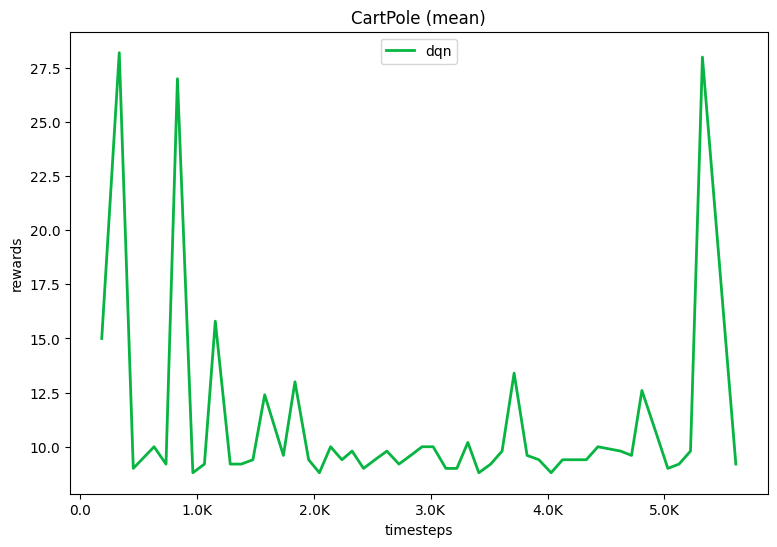

In [11]:
main_loop(config)